<a href="https://colab.research.google.com/github/ewattudo/datamanagement/blob/main/ps4_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PS4 - Emperical Ananlysis of Hunter and Robinsons' (2018) C*hocolate Cities* Map

# Setup, Import, Manipulation and Merge

## Setup Code

In [115]:
#Using code from previous projects and Dr. Adam
import time, os, sys, re #basics
import zipfile, json, datetime, string
import numpy as np #basic math
from statistics import * #stats

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.patches as mpatches

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
import requests

import missingno as msno

from google.colab import files

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.max_columns = 50

import pandas as pd
import urllib.request
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

!pip install geopandas==1.0.1
!pip install mapclassify
import geopandas as gpd

import time, webbrowser, zipfile

from google.colab import data_table
data_table.enable_dataframe_formatter()

import plotly.express as px
import plotly.graph_objects as go

!pip install ydata-profiling
from ydata_profiling import ProfileReport

from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

!pip install adjustText
from adjustText import adjust_text

!pip install tabula-py
import tabula

## US Map (SHP) Import and Manipulation

### US Map (SHP) Import

**Source: US Census:**
https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip

**Project for the future:** I really want a US map with Hawaii and Alaska inset. I tried to find one quite unsuccessfully.

In [68]:
! wget -q -O US.zip https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip

zip_ref = zipfile.ZipFile('US.zip', 'r'); zip_ref.extractall(); zip_ref.close()

In [69]:
US=gpd.read_file('/content/cb_2018_us_state_500k.shp')

### US Map (SHP) Manipulation

Having used this data before, I know that I am goning to have to rename some fields for merging and get rid of some of the states.

In [70]:
#I am going to have to rename NAME
US.dtypes

,0
STATEFP,object
STATENS,object
AFFGEOID,object
GEOID,object
STUSPS,object
NAME,object
LSAD,object
ALAND,int64
AWATER,int64
geometry,geometry


In [71]:
#I want to rename NAME colume to State
US.rename(columns={'NAME':'State'}, inplace=True)

In [72]:
#I only want to look at states, not territories.
#I removed HI and AK, but if I do this for further study. I can't remove them, but the map looks off when I include them.
US = US[~US['State'].isin(['Alaska','District of Columbia','Hawaii','Puerto Rico','American Samoa','United States Virgin Islands','Guam','Commonwealth of the Northern Mariana Islands'])]

## State Political Party Composition (PDF) Import and Manipulation

### State Political Party Composition (PDF) Import

In [73]:
#I was able to get this PDF extraction code from https://colab.research.google.com/github/Jonchyk/Datamgmt/blob/main/PS2Complex.ipynb#scrollTo=qOV77LSLJCkM.
#This is going to need some manipulating. I might want to dig down in this in my dissertation, but for this project. I think I am going to focus on using this as categorical data.
!wget --no-check-certificate "https://documents.ncsl.org/wwwncsl/Elections/LegisControl_2010.pdf" -O leg2010.pdf
leg = tabula.read_pdf('leg2010.pdf', multiple_tables=False, stream=True)
leg[0].head()

--2025-03-22 19:40:04--  https://documents.ncsl.org/wwwncsl/Elections/LegisControl_2010.pdf
Resolving documents.ncsl.org (documents.ncsl.org)... 13.107.246.70, 2620:1ec:bdf::70
Connecting to documents.ncsl.org (documents.ncsl.org)|13.107.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117163 (114K) [application/pdf]
Saving to: ‘leg2010.pdf’

leg2010.pdf         100%[===================>] 114.42K  --.-KB/s    in 0.02s   

2025-03-22 19:40:05 (7.27 MB/s) - ‘leg2010.pdf’ saved [117163/117163]



Mar 22, 2025 7:40:06 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Mar 22, 2025 7:40:16 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Mar 22, 2025 7:40:16 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>



,Unnamed: 0,Total,Total.1,Senate Senate,Senate,Unnamed: 5,Total.2,House House,House,Unnamed: 9,Legis.,Gov.,State
0,STATE,Seats,Senate,Dem. Rep.,NaN,other,House,Dem. Rep.,NaN,other,Control,Party,Control
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem


### State Political Party Composition (PDF) Manipulation

In [74]:
#This doesn't look right. The first row is nonsense.
leg[0].columns = leg[0].columns.astype(str) + '_' + leg[0].iloc[0].astype(str)
leg[0].head()

,Unnamed: 0_STATE,Total_Seats,Total.1_Senate,Senate Senate_Dem. Rep.,Senate_nan,Unnamed: 5_other,Total.2_House,House House_Dem. Rep.,House_nan,Unnamed: 9_other,Legis._Control,Gov._Party,State_Control
0,STATE,Seats,Senate,Dem. Rep.,NaN,other,House,Dem. Rep.,NaN,other,Control,Party,Control
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem


In [75]:
#I want to remove the row 0 it is not data, it's merge error.
leg[0] = leg[0].drop(0)

In [76]:
#This is not quite there, but it's usable. I am not going to edit all these columns.
leg[0].head()

,Unnamed: 0_STATE,Total_Seats,Total.1_Senate,Senate Senate_Dem. Rep.,Senate_nan,Unnamed: 5_other,Total.2_House,House House_Dem. Rep.,House_nan,Unnamed: 9_other,Legis._Control,Gov._Party,State_Control
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem
5,California,120,40,25 14,NaN,1v,80,49 29,NaN,"1, 1v",Dem,Rep,Divided


In [77]:
#I want the numbers here for future study, largely because of Furrer, et al (2023), referred to previously. The categorization here is a gross simplification done for parsimony.
#I want to make the leg dataset, Unnamed: 0_State and State_Control
leg[0] = leg[0].rename(columns={'Unnamed: 0_STATE': 'State', 'State_Control': 'Party'})
leg[0].head()

,State,Total_Seats,Total.1_Senate,Senate Senate_Dem. Rep.,Senate_nan,Unnamed: 5_other,Total.2_House,House House_Dem. Rep.,House_nan,Unnamed: 9_other,Legis._Control,Gov._Party,Party
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem
5,California,120,40,25 14,NaN,1v,80,49 29,NaN,"1, 1v",Dem,Rep,Divided


In [78]:
#I want to create a leg df from leg[0]
leg = leg[0]

In [79]:
#I want to create the leg2020 df that includes State and Party only.
leg2010 = leg[['State', 'Party']]
leg2010.head()

,State,Party
1,Alabama,Divided
2,Alaska,Divided
3,Arizona,Rep
4,Arkansas,Dem
5,California,Divided


## Creating the Chocolate Cities Base Map

### Using Mapping to Create the AllSouth FIeld

In [90]:
#Revised Chocolate Cities-style region mapping
chocolate_cities_mapping = {
    # OUT SOUTH
    "Montana": "OUT SOUTH", "Wyoming": "OUT SOUTH", "Idaho": "OUT SOUTH",
    "Washington": "OUT SOUTH", "Oregon": "OUT SOUTH",

    # WEST SOUTH
    "Colorado": "WEST SOUTH", "New Mexico": "WEST SOUTH", "Arizona": "WEST SOUTH", "Utah": "WEST SOUTH",
    "California": "WEST SOUTH", "Nevada": "WEST SOUTH", "Texas": "WEST SOUTH",

    # MID SOUTH
    "Missouri": "MID SOUTH", "Kansas": "MID SOUTH", "Illinois": "MID SOUTH",
    "Indiana": "MID SOUTH", "Iowa": "MID SOUTH", "Nebraska": "MID SOUTH",
    "Michigan": "MID SOUTH", "Oklahoma": "MID SOUTH", "South Dakota": "MID SOUTH",
    "Ohio": "MID SOUTH", "Wisconsin": "MID SOUTH", "Minnesota": "MID SOUTH",
    "North Dakota": "MID SOUTH", "Kentucky": "MID SOUTH", "West Virginia": "MID SOUTH",

    # UP SOUTH
    "New York": "UP SOUTH", "Massachusetts": "UP SOUTH", "Connecticut": "UP SOUTH",
    "Rhode Island": "UP SOUTH", "New Jersey": "UP SOUTH", "Vermont": "UP SOUTH",
    "New Hampshire": "UP SOUTH", "Maine": "UP SOUTH", "Pennsylvania": "UP SOUTH",
    "Maryland": "UP SOUTH", "Delaware": "UP SOUTH",

    # DOWN SOUTH
    "Virginia": "DOWN SOUTH", "North Carolina": "DOWN SOUTH", "South Carolina": "DOWN SOUTH",
    "Florida": "DOWN SOUTH", "Georgia": "DOWN SOUTH",

    # DEEP SOUTH
    "Alabama": "DEEP SOUTH", "Mississippi": "DEEP SOUTH",
    "Louisiana": "DEEP SOUTH", "Tennessee": "DEEP SOUTH", "Arkansas": "DEEP SOUTH"
}

# Apply the updated mapping to your GeoDataFrame
US["AllSouth"] = US["State"].map(chocolate_cities_mapping)

In [91]:
#Checking to see if I missed any states
US[US["AllSouth"].isnull()]["State"]

,State


## Merging

In [80]:
#I want to merge US and leg2010 outer on State
US = pd.merge(US, leg2010, on='State', how='outer',indicator=True)

In [84]:
#I want to see the results of the _merge field
US['_merge'].value_counts()

,count
_merge,
both,48
right_only,12
left_only,0


In [85]:
#I want to see the values in the right_only in _merge
#This looks right, it's all terrirtories, and non states. I always lament not being able to include Alaska and Hawaii. But Hunter and Robinson (2018) don't either.
US[US['_merge'] == 'right_only']

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,ALAND,AWATER,geometry,Party,_merge,AllSouth
1,NaN,NaN,NaN,NaN,NaN,Alaska,NaN,NaN,NaN,None,Divided,right_only,NaN
2,NaN,NaN,NaN,NaN,NaN,American Samoa,NaN,NaN,NaN,None,NaN,right_only,NaN
9,NaN,NaN,NaN,NaN,NaN,District of Columbia,NaN,NaN,NaN,None,NaN,right_only,NaN
12,NaN,NaN,NaN,NaN,NaN,Guam,NaN,NaN,NaN,None,Divided,right_only,NaN
13,NaN,NaN,NaN,NaN,NaN,Hawaii,NaN,NaN,NaN,None,Divided,right_only,NaN
22,NaN,NaN,NaN,NaN,NaN,Mariana Islands,NaN,NaN,NaN,None,Divided,right_only,NaN
42,NaN,NaN,NaN,NaN,NaN,Puerto Rico,NaN,NaN,NaN,None,NPP,right_only,NaN
48,NaN,NaN,NaN,NaN,NaN,Total,NaN,NaN,NaN,None,24 Div,right_only,NaN
49,NaN,NaN,NaN,NaN,NaN,U.S. Territories,NaN,NaN,NaN,None,Control,right_only,NaN
52,NaN,NaN,NaN,NaN,NaN,Virgin Islands,NaN,NaN,NaN,None,NaN,right_only,NaN


In [88]:
#In US I want to delete all the values where _merge is right_only and then I wantto delete the _merge field
US = US[US['_merge'] != 'right_only']
US = US.drop(columns=['_merge'])

In [94]:
#I want to count in US of States by Party
#Interesting, I didn't anticipate that it would be so divided. I thought it would be overwelmingly Rep.
US['Party'].value_counts()

,count
Party,
Divided,22
Dem,16
Rep,9


### Merged FIle Manipulation: Reshaping Party Data

In [112]:
#I want to create a down_party df that includes Party, AllSouth and create a new field called Total so I can create sunbursts
down_party = (
    US.groupby(['Party', 'AllSouth'])
      .size()
      .reset_index(name='Total')
)
down_party.head(10)

,Party,AllSouth,Total
0,Dem,DEEP SOUTH,1
1,Dem,DOWN SOUTH,1
2,Dem,MID SOUTH,4
3,Dem,OUT SOUTH,2
4,Dem,UP SOUTH,6
5,Dem,WEST SOUTH,2
6,Divided,DEEP SOUTH,4
7,Divided,DOWN SOUTH,1
8,Divided,MID SOUTH,8
9,Divided,OUT SOUTH,2


#*Chocolate Cities* Analysis

## Chocolate Cities Base Map

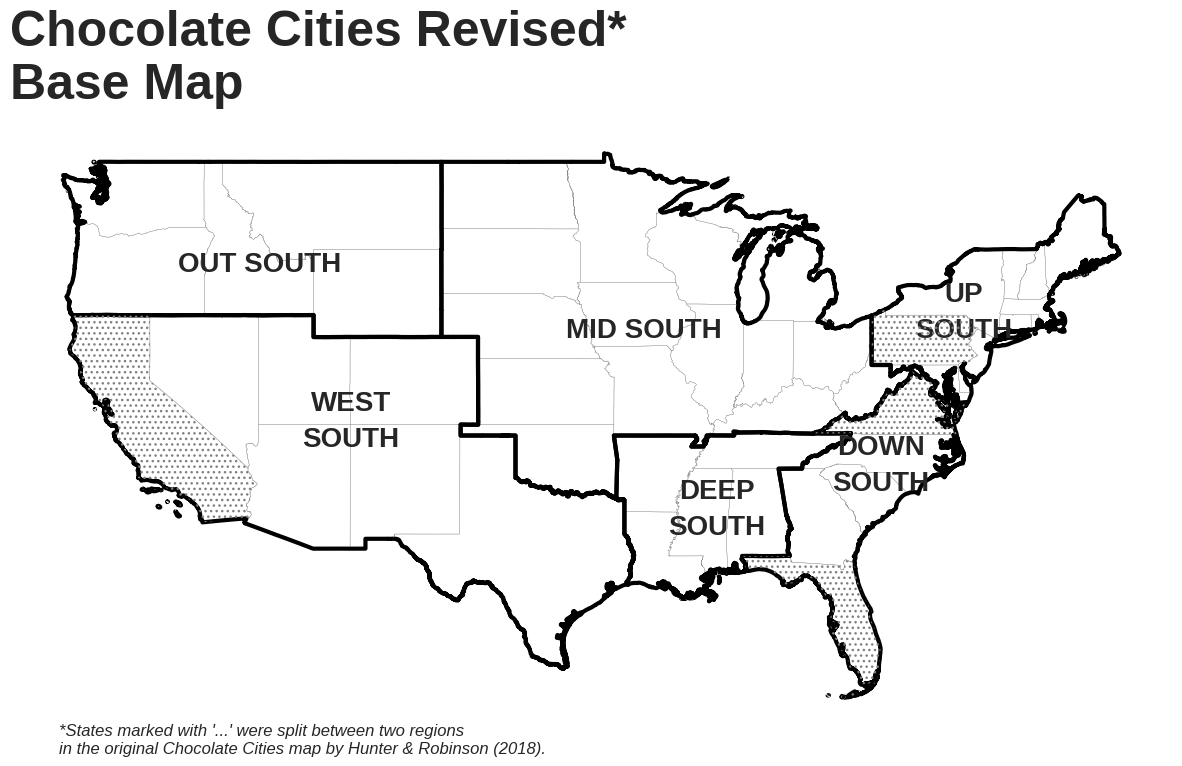

In [92]:
regions = US.dissolve(by='AllSouth')

fig, ax = plt.subplots(1, figsize=(15, 50))

US.boundary.plot(ax=ax, edgecolor='grey', linewidth=0.20)

regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Clean up axes
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Large, two-line title using ax.set_title with increased padding
ax.set_title("Chocolate Cities Revised*\nBase Map",
             loc='left', fontsize=36, fontweight='bold', pad=20)

ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).",
        fontsize=12, ha='left', fontstyle='italic')

# Final label positions and text
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),   # moved slightly right
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}

label_text = {
    "OUT SOUTH": "OUT SOUTH",           # one line
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",           # one line
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}

# Add labels
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Overlay hatch on split states (California, Virginia, Florida, Pennsylvania)
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]

split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5  # Keep it above other layers
)

plt.show()

## Chocolate Cities Map Evaluating Political Party Control

In [105]:
#I want a pivot that groups by AllSOuth and Counts values in Party
US.pivot_table(index='Party', columns='AllSouth', values='State', aggfunc='count')

AllSouth,DEEP SOUTH,DOWN SOUTH,MID SOUTH,OUT SOUTH,UP SOUTH,WEST SOUTH
Party,,,,,,
Dem,1.0,1.0,4.0,2.0,6.0,2.0
Divided,4.0,1.0,8.0,2.0,5.0,2.0
Rep,NaN,3.0,2.0,1.0,NaN,3.0


In [100]:
# The map wasn't rendering because Nebraska has a nonpartisan legislature.
US[US['Party'].isna()][['State']]

,State
30,Nebraska


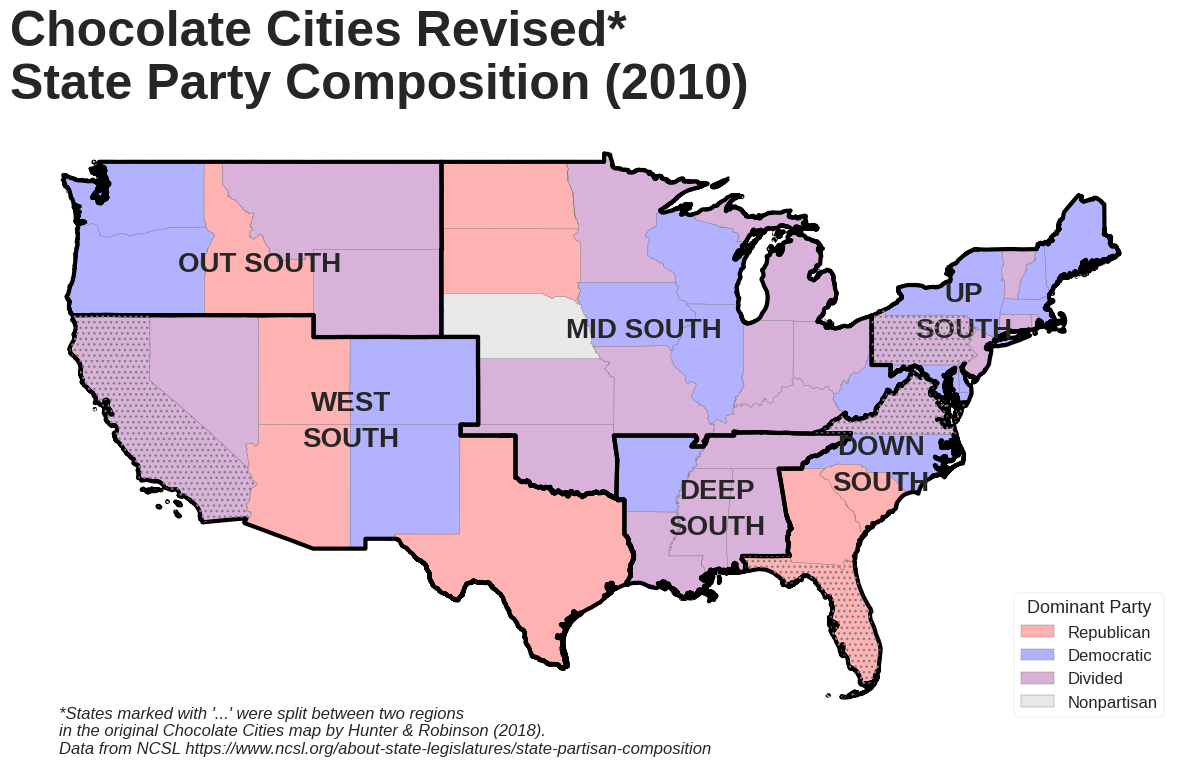

In [121]:
# Create regional geometries from the AllSouth column
regions = US.dissolve(by='AllSouth')

# Start plot
fig, ax = plt.subplots(1, figsize=(15, 50))

# Handle missing values
US['Party_filled'] = US['Party'].fillna('Other')

party_colors = {
    'Rep': (1, 0, 0, 0.3),       # soft red
    'Dem': (0, 0, 1, 0.3),       # soft blue
    'Divided': (0.5, 0, 0.5, 0.3),  # soft purple
    'Other': (0.7, 0.7, 0.7, 0.3)   # soft gray
}

# Now plot
US.plot(ax=ax,
        color=US['Party_filled'].map(party_colors),
        edgecolor='grey',
        linewidth=0.20)

# Now layer region outlines
regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Axes cleanup
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Title
ax.set_title("Chocolate Cities Revised*\nState Party Composition (2010) ",
             loc='left', fontsize=36, fontweight='bold', pad=20)

# Annotation
ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).\nData from NCSL https://www.ncsl.org/about-state-legislatures/state-partisan-composition",
        fontsize=12, ha='left', fontstyle='italic')

# Region label positions
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Hatched overlay on split states
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]
split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5
)

# Custom legend using mpatches
legend_elements = [
    mpatches.Patch(facecolor=(1, 0, 0, 0.3), edgecolor='grey', label='Republican'),
    mpatches.Patch(facecolor=(0, 0, 1, 0.3), edgecolor='grey', label='Democratic'),
    mpatches.Patch(facecolor=(0.5, 0, 0.5, 0.3), edgecolor='grey', label='Divided'),
    mpatches.Patch(facecolor=(0.7, 0.7, 0.7, 0.3), edgecolor='grey', label='Nonpartisan')
]

# Add legend to the plot
ax.legend(handles=legend_elements, title='Dominant Party',
          loc='lower right', fontsize=12, title_fontsize=13, frameon=True, facecolor='white')

# Show final map
plt.show()

In [120]:
# Create sunburst 1: Party → Region
fig1 = px.sunburst(
    down_party,
    path=['Party', 'AllSouth'],
    values='Total',  # or 'count' if that's the column name
    color='Party',
    color_discrete_map={
        'Dem': 'blue',
        'Rep': 'red',
        'Divided': 'purple'
    }
)

# Create sunburst 2: Region → Party, using Party for consistent color mapping
fig2 = px.sunburst(
    down_party,
    path=['AllSouth', 'Party'],
    values='Total',  # or 'count'
    color='Party',
    color_discrete_map={
        'Dem': 'blue',
        'Rep': 'red',
        'Divided': 'purple'
    }
)

# Set up side-by-side layout
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "domain"}, {"type": "domain"}]],
    subplot_titles=("By Party → Region", "By Region → Party")
)

# Add the two sunbursts to the subplot
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

# Final layout adjustments
fig.update_layout(
    title_text="Chocolate Cities State Party Composition",
    title_x=0.5,
    margin=dict(t=80, l=0, r=0, b=0)
)

fig.show()